# Some code that allowed to make conclusions made in README file

It is here to allow people to verify that the claims made in the README file are not baseless.
The code quality here barely allows reading and understanding what is going on, and it is not suggested to do so.

| **COMBINATION** | **SCORE** | **IMG#1** | **IMG#2** | **IMG#3** | **IMG#4** | **IMG#5** | **IMG#6** | **IMG#7** | **IMG#8** | **IMG#9** | **IMG#10** | **IMG#11** | **IMG#12** | **IMG#13** | **IMG#14** | **IMG#15** | **IMG#16** | **IMG#17** | **IMG#18** |  
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|  
| SHITOMASI_SIFT_HOG_FLANN_NN | 0.972 | **L**:14.87 <br> **C**:14.28 | **L**:12.23 <br> **C**:13.04 | N/A | **L**:13.01 <br> **C**:12.87 | **L**:11.87 <br> **C**:11.96 | **L**:10.61 <br> **C**:13.58 | **L**:15.25 <br> **C**:13.29 | **L**:15.65 <br> **C**:13.99 | **L**:12.35 <br> **C**:12.04 | **L**:14.69 <br> **C**:14.08 | **L**:12.72 <br> **C**:12.00 | **L**:9.76 <br> **C**:12.01 | **L**:8.89 <br> **C**:12.08 | **L**:9.95 <br> **C**:12.47 | **L**:7.77 <br> **C**:12.46 | **L**:10.37 <br> **C**:11.99 | **L**:10.89 <br> **C**:11.34 | N/A |  
| SHITOMASI_SIFT_HOG_BF_NN | 0.911 | **L**:14.87 <br> **C**:14.07 | **L**:12.23 <br> **C**:13.74 | N/A | **L**:

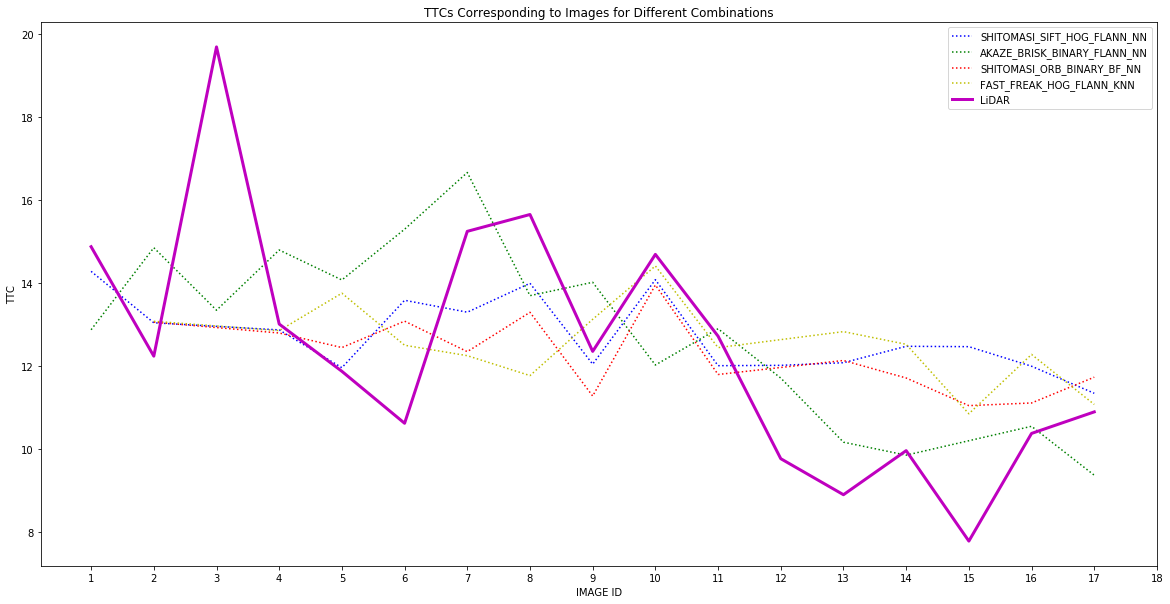

In [76]:


import os
import csv
import numpy as np
import pandas as pd
from glob import glob
from collections import OrderedDict
import matplotlib.pyplot as plt

data_dir = "data"

all_dfs = OrderedDict()

# read data
class LineWrapper:
    def __init__(self, 
                 detector, 
                 descriptor, 
                 descriptor_type,
                 matcher,
                 selector,
                 lst):
        self._lst = lst
        self._detector = detector
        self._descriptor = descriptor
        self._descriptor_type = descriptor_type
        self._matcher = matcher
        self._selector = selector
        
    def detector(self):
        return self._detector
    
    def descriptor(self):
        return self._descriptor
    
    def descriptor_type(self):
        return self._descriptor_type
    
    def matcher(self):
        return self._matcher
    
    def selector(self):
        return self._selector
        
    def prev_img(self):
        return int(self._lst[0]) - 1
    
    def cur_img(self):
        return int(self._lst[0])
    
    def lidar_ttc(self):
        return float(self._lst[1])
    
    def camera_ttc(self):
        return float(self._lst[2])

files = glob(os.path.join(data_dir, '*.txt'))
for file in files:
    file_name = os.path.basename(file).split('.')[0]
    det, desc, desc_type, mat, sel = file_name.split('_')
    
    data = pd.read_csv(file, sep=' ', header=0)

    if   data.isna().values.sum() \
       + data.isin([-np.inf, np.inf]).values.sum() \
       + data.isnull().values.sum() == 0 \
       and \
       ( data['ttc_camera'] < 5).values.sum() == 0  \
       and  \
       ( data['ttc_camera'] > 25).values.sum() == 0  \
       and \
       ( data['ttc_lidar'] < 5).values.sum() == 0  \
       and  \
       ( data['ttc_lidar'] > 25).values.sum() == 0:
        
        data['ttc_avg'] = (data['ttc_lidar'] + data['ttc_camera']) / 2.0
        data['ttc_diff'] = data['ttc_lidar'] - data['ttc_camera']
        
        data['delta_ttc_avg']   = np.hstack((0, data['ttc_avg'].values[1:]   - data['ttc_avg'].values[:-1]))
        data['delta_ttc_lidar'] = np.hstack((0, data['ttc_lidar'].values[1:] - data['ttc_lidar'].values[:-1]))
        data['delta_ttc_camera'] = np.hstack((0, data['ttc_camera'].values[1:] - data['ttc_camera'].values[:-1]))
    
    
        all_dfs[file_name] = {
            'data': data, 
            'count': len(data),
            'mae_ttc_diff':          data['ttc_diff'].abs().mean(),
            'rmse_delta_ttc_lidar':  ((data['delta_ttc_lidar'][1:]) ** 2).mean() ** 0.5,
            'rmse_delta_ttc_camera': ((data['delta_ttc_camera'][1:]) ** 2).mean() ** 0.5,
            'rmse_delta_ttc_avg':    ((data['delta_ttc_avg'][1:]) ** 2).mean() ** 0.5,
        }
        all_dfs[file_name]['sum_of_rmses'] =                \
            all_dfs[file_name][ 'rmse_delta_ttc_lidar'  ] + \
            all_dfs[file_name][ 'rmse_delta_ttc_camera' ] + \
            all_dfs[file_name][ 'rmse_delta_ttc_avg'    ]
    else:
        pass #print(file_name, '\n', data, '\n')

min_mae,  max_mae  = None, None
min_rmse, max_rmse = None, None
min_count, max_count = None, None
for key, val in all_dfs.items():
    if not min_mae or min_mae > val['mae_ttc_diff']:
        min_mae = val['mae_ttc_diff']
    if not max_mae or max_mae < val['mae_ttc_diff']:
        max_mae = val['mae_ttc_diff']

    if not min_rmse or min_rmse > val['sum_of_rmses']:
        min_rmse = val['sum_of_rmses']
    if not max_rmse or max_rmse < val['sum_of_rmses']:
        max_rmse = val['sum_of_rmses']

    if not min_count or min_count > val['count']:
        min_count = val['count']
    if not max_count or max_count < val['count']:
        max_count = val['count']


assert None not in [min_mae, max_mae, min_rmse, max_rmse, min_count, max_count]
assert min_mae <= max_mae
assert min_rmse <= max_rmse
assert min_count <= max_count

mae_score   = lambda mae:   1 - (mae   - min_mae)   / (max_mae   - min_mae)
rmse_score  = lambda rmse:  1 - (rmse  - min_rmse)  / (max_rmse  - min_rmse)
count_score = lambda count: (count - min_count) / (max_count - min_count)

for combination_id, data in all_dfs.items():
    data['mae_score']   = mae_score(   data['mae_ttc_diff'] )
    data['rmse_score']  = rmse_score(  data['sum_of_rmses'] )
    data['count_score'] = count_score( data['count']        )
    data['total_score'] = 1./3. * (data['mae_score'] + data['rmse_score'] + data['count_score'])

all_dfs = OrderedDict(reversed(sorted(list(all_dfs.items()), key=lambda key_val: key_val[1]['total_score'])))


# for key, val in all_dfs.items():
#     print(f"combination_id = {key}\n",
#           f"total_score = {val['total_score']}\n",
#           f"mae_score   = {val['mae_score']}\n",
#           f"rmse_score  = {val['rmse_score']}\n",
#           f"count_score = {val['count_score']}\n",
#           val['data'], '\n')

table = "| **COMBINATION** | **SCORE** | "
for i in range(1, 19):
    table += f"**IMG#{i}** | "
table += " \n|" + (":-:|" * 20) + "  \n"
    
combinations = list(all_dfs.items())[0:10]
for comb_id, data in combinations:
    img_id_in_line = 1
    table += f"| {comb_id} | {data['total_score']:.3f} | "
    for row in data['data'].iterrows():
        while row[1]['image_id'] > img_id_in_line:
            table += "N/A | "
            img_id_in_line += 1
        table += f"**L**:{row[1]['ttc_lidar']:.2f} <br> **C**:{row[1]['ttc_camera']:.2f} | "
        img_id_in_line += 1
    while img_id_in_line < 19:
        table += "N/A | "
        img_id_in_line += 1
    table += " \n"
    
print(table)


combinations = [
    ( 'SHITOMASI_SIFT_HOG_FLANN_NN', all_dfs['SHITOMASI_SIFT_HOG_FLANN_NN'] ),
    ( 'AKAZE_BRISK_BINARY_FLANN_NN', all_dfs['AKAZE_BRISK_BINARY_FLANN_NN'] ),
    ( 'SHITOMASI_ORB_BINARY_BF_NN', all_dfs['SHITOMASI_ORB_BINARY_BF_NN'] ),
    ( 'FAST_FREAK_HOG_FLANN_KNN', all_dfs['FAST_FREAK_HOG_FLANN_KNN'] ),
]

colors = ['b', 'g', 'r', 'y']
ind = 0
plt.figure(figsize=(20, 10))
lidar_img_ttc = OrderedDict()
for comb_id, data in combinations:
    plt.plot(data['data']['image_id'], data['data']['ttc_camera'], linestyle='dotted', color=colors[ind], label=comb_id)
    for j in range(len(data['data']['image_id'])):
        lidar_img_ttc[data['data']['image_id'][j]] = data['data']['ttc_lidar'][j]
    ind += 1
lidar_img_ttc = OrderedDict(sorted(lidar_img_ttc.items()))
plt.plot(list(lidar_img_ttc.keys()), list(lidar_img_ttc.values()), linestyle='solid', linewidth=3, label='LiDAR', color='m')
plt.legend()
plt.xticks(list(range(1, 19)))
plt.ylabel('TTC')
plt.xlabel('IMAGE ID')
plt.title('TTCs Corresponding to Images for Different Combinations')
plt.show()
